In [1]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from random import seed
from random import randint


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report as cr

In [2]:
seed = 16
filename = '../Datos/fer2013.csv'
label_map = ['Enfado', 'Asco', 'Miedo', 'Alegria', 'Tristeza', 'Sorpresa', 'Neutral']
label_map = np.array(label_map)
names=['emocion','pixels','uso']
df=pd.read_csv(filename,names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emocion,pixels,uso
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [3]:
def loadData(filname):
    
    Y_train = []
    X_train = []
    Y_test = []
    X_test = []
    
    first = True
    uso = 'Training\n'
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            condition = str(row[2])
            if condition == 'Training\n':
                Y_train.append(int(row[0]))
                X_train.append([int(p) for p in row[1].split()])
            else:
                Y_test.append(int(row[0]))
                X_test.append([int(p) for p in row[1].split()])
                
    X_train, Y_train = np.array(X_train)/255.0 , np.array(Y_train)
    X_test, Y_test = np.array(X_test)/255.0 , np.array(Y_test)

    return X_train, X_test, Y_train, Y_test 

In [4]:
X_train, X_test, Y_train, Y_test= loadData(filename)

In [5]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = X_train.reshape(N_train, 48, 48,1)
X_test = X_test.reshape(N_test, 48, 48,1)

In [6]:
# one hot encode output
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
class_num = Y_test.shape[1]

In [12]:
model = Sequential()
model.add(Conv2D(64,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(class_num, activation='softmax'))

model.summary()
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              18875392  
_________________________________________________________________
dense_13 (Dense)             (None, 2048)             

In [13]:
epochs = 100

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mc = ModelCheckpoint('.bcnn_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')

np.random.seed(16)
cb =  [es,mc,rlr]
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 541s 1s/step - loss: 1.6761 - accuracy: 0.3315 - val_loss: 1.5281 - val_accuracy: 0.4067 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 421s 939ms/step - loss: 1.4530 - accuracy: 0.4360 - val_loss: 1.3850 - val_accuracy: 0.4636 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 619s 1s/step - loss: 1.3097 - accuracy: 0.4997 - val_loss: 1.3235 - val_accuracy: 0.4890 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 580s 1s/step - loss: 1.1717 - accuracy: 0.5547 - val_loss: 1.3208 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 639s 1s/step - loss: 0.9959 - accuracy: 0.6270 - val_loss: 1.3518 - val_accuracy: 0.5206 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 529s 1s/step - loss: 0.7839 - accuracy: 0.7152 - val_loss: 1.4448 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 7/100
449/449 [==============================] - 

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
  
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(-0.5, 6.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix
[[ 726    0   16   76   76    8   56]
 [  86   10    0    8    6    0    1]
 [ 652    0   93   82  111   36   50]
 [ 494    1    3 1175   69   10   22]
 [ 786    0    7   82  291    6   75]
 [ 350    1   13   50   18  372   27]
 [ 692    2    6  101   80    2  350]]
              precision    recall  f1-score   support

      Enfado       0.19      0.76      0.31       958
        Asco       0.71      0.09      0.16       111
       Miedo       0.67      0.09      0.16      1024
     Alegria       0.75      0.66      0.70      1774
    Tristeza       0.45      0.23      0.31      1247
    Sorpresa       0.86      0.45      0.59       831
     Neutral       0.60      0.28      0.39      1233

    accuracy                           0.42      7178
   macro avg       0.60      0.37      0.37      7178
weighted avg       0.60      0.42      0.43      7178



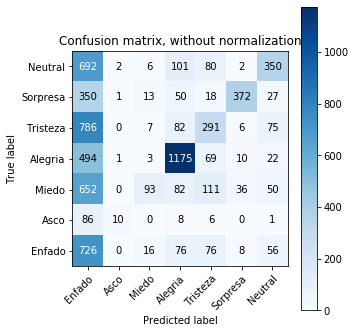

In [15]:
model.load_weights('.bcnn_1.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))


In [16]:
model = Sequential()
model.add(Conv2D(64,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(class_num, activation='softmax'))

model.summary()
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)             

In [17]:
mc = ModelCheckpoint('.bcnn_2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 272s 606ms/step - loss: 1.7853 - accuracy: 0.2656 - val_loss: 1.7047 - val_accuracy: 0.2875 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 315s 702ms/step - loss: 1.5695 - accuracy: 0.3793 - val_loss: 1.4679 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 328s 730ms/step - loss: 1.4235 - accuracy: 0.4465 - val_loss: 1.3762 - val_accuracy: 0.4727 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 322s 716ms/step - loss: 1.3080 - accuracy: 0.4966 - val_loss: 1.3327 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 320s 712ms/step - loss: 1.1873 - accuracy: 0.5472 - val_loss: 1.2811 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 324s 721ms/step - loss: 1.0615 - accuracy: 0.5998 - val_loss: 1.3019 - val_accuracy: 0.5259 - lr: 0.0010
Epoch 7/100
449/449 [===================

Confusion matrix
[[ 808    1   11   39   55   14   30]
 [  91   11    0    4    3    2    0]
 [ 728    0   82   36   76   67   35]
 [ 600    0    3 1098   33   19   21]
 [ 919    0    5   54  187   11   71]
 [ 320    0   15   31    7  447   11]
 [ 789    2    8   75   50   14  295]]
              precision    recall  f1-score   support

      Enfado       0.19      0.84      0.31       958
        Asco       0.79      0.10      0.18       111
       Miedo       0.66      0.08      0.14      1024
     Alegria       0.82      0.62      0.71      1774
    Tristeza       0.45      0.15      0.23      1247
    Sorpresa       0.78      0.54      0.64       831
     Neutral       0.64      0.24      0.35      1233

    accuracy                           0.41      7178
   macro avg       0.62      0.37      0.36      7178
weighted avg       0.61      0.41      0.41      7178



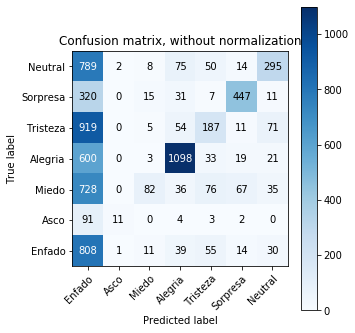

In [18]:
model.load_weights('.bcnn_2.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [19]:
model = Sequential()
model.add(Conv2D(64,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax'))

model.summary()
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)      

In [20]:
mc = ModelCheckpoint('.bcnn_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 522s 1s/step - loss: 2.0266 - accuracy: 0.2918 - val_loss: 2.2953 - val_accuracy: 0.2587 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 541s 1s/step - loss: 1.6119 - accuracy: 0.4038 - val_loss: 4.2094 - val_accuracy: 0.1517 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 534s 1s/step - loss: 1.4343 - accuracy: 0.4720 - val_loss: 3.3297 - val_accuracy: 0.3565 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 532s 1s/step - loss: 1.3260 - accuracy: 0.5100 - val_loss: 1.9613 - val_accuracy: 0.3806 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 530s 1s/step - loss: 1.2273 - accuracy: 0.5390 - val_loss: 1.6812 - val_accuracy: 0.3720 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 534s 1s/step - loss: 1.1474 - accuracy: 0.5721 - val_loss: 1.4481 - val_accuracy: 0.4862 - lr: 0.0010
Epoch 7/100
449/449 [==============================] - 529

Confusion matrix
[[755   3   2  15 126  12  45]
 [ 85  12   0   3   9   0   2]
 [637   0  35  18 224  62  48]
 [644   0   1 976 100  17  36]
 [681   0   5  28 456   7  70]
 [371   0   3  21  16 398  22]
 [757   0   0  22 169   7 278]]
              precision    recall  f1-score   support

      Enfado       0.19      0.79      0.31       958
        Asco       0.80      0.11      0.19       111
       Miedo       0.76      0.03      0.07      1024
     Alegria       0.90      0.55      0.68      1774
    Tristeza       0.41      0.37      0.39      1247
    Sorpresa       0.79      0.48      0.60       831
     Neutral       0.55      0.23      0.32      1233

    accuracy                           0.41      7178
   macro avg       0.63      0.36      0.36      7178
weighted avg       0.63      0.41      0.41      7178



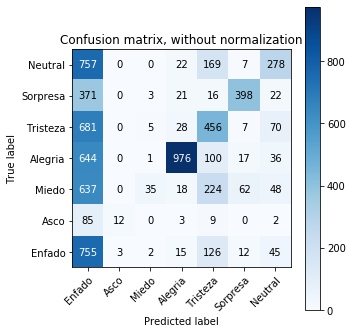

In [21]:
model.load_weights('.bcnn_3.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))


In [ ]:
model = Sequential()
model.add(Conv2D(64,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Conv2D(64,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Conv2D(128,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(256,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(class_num, activation='softmax'))

model.summary()
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
mc = ModelCheckpoint('.bcnn_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

In [ ]:
model.load_weights('.bcnn_4.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [14]:
model = Sequential()
model.add(Conv2D(64,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Conv2D(64,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Conv2D(128,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(256,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax'))

model.summary()
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)      

In [15]:
mc = ModelCheckpoint('.bcnn_5.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 876s 2s/step - loss: 2.0750 - accuracy: 0.2644 - val_loss: 2.9524 - val_accuracy: 0.2558 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 898s 2s/step - loss: 1.7136 - accuracy: 0.3587 - val_loss: 2.0527 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 895s 2s/step - loss: 1.5219 - accuracy: 0.4248 - val_loss: 1.5227 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 893s 2s/step - loss: 1.3540 - accuracy: 0.4880 - val_loss: 1.7629 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 887s 2s/step - loss: 1.2424 - accuracy: 0.5348 - val_loss: 1.7250 - val_accuracy: 0.4370 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 880s 2s/step - loss: 1.1511 - accuracy: 0.5682 - val_loss: 1.4276 - val_accuracy: 0.5017 - lr: 0.0010
Epoch 7/100
449/449 [==============================] - 882

Confusion matrix
[[ 528    1   11   31  263    5  119]
 [  62   15    0    3   26    0    5]
 [ 436    1   64   21  335   49  118]
 [ 299    0    4 1205  127   28  111]
 [ 304    0    8   28  685    9  213]
 [ 269    1   38   32   37  406   48]
 [ 300    0    3   43  282    3  602]]
              precision    recall  f1-score   support

      Enfado       0.24      0.55      0.33       958
        Asco       0.83      0.14      0.23       111
       Miedo       0.50      0.06      0.11      1024
     Alegria       0.88      0.68      0.77      1774
    Tristeza       0.39      0.55      0.46      1247
    Sorpresa       0.81      0.49      0.61       831
     Neutral       0.50      0.49      0.49      1233

    accuracy                           0.49      7178
   macro avg       0.59      0.42      0.43      7178
weighted avg       0.58      0.49      0.49      7178



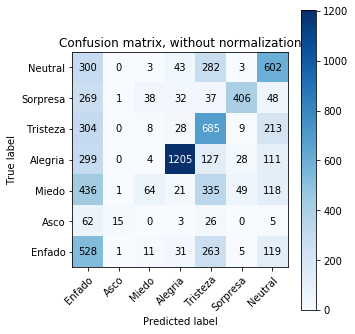

In [16]:
model.load_weights('.bcnn_5.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [17]:
X_train, X_test, Y_train, Y_test= loadData(filename)
X_train = X_train.reshape(N_train, 48, 48)

In [18]:
def mirror(img):
    copy = img.copy()
    indx = range(copy.shape[1]-1, -1, -1)
    copy = np.flip(copy, axis = 1)
    return copy


def random_erasing(img):
    copy = img.copy()
    numero_parches=(randint(1,3))
    for i in range(numero_parches):
        tam_h = randint(5,15)
        tam_v = randint(5,15)   
        start_h = randint(0,copy.shape[1]-tam_h)
        start_v = randint(0,copy.shape[0]-tam_v) 
        for i in range(tam_v):
            for j in range(tam_h):
                copy[start_v+i, start_h+j] = 1
    return copy


def tras_x(img, tras):
    order = []
    for i in range(tras):
        order = order + [0]
    order = order + list(range(img.shape[1]- tras))
    copy = img[:,order]
    return copy


def tras_y(img, tras):
    order = []
    for i in range(tras):
        order = order + [0]
    order = order + list(range(img.shape[0]- tras))
    copy = img[order,:]
    return copy

In [19]:
nuevo = []
etiquetas = []


for i in range(N_train):
    
    if np.random.random() < 0.5:
        n = mirror(X_train[i])
        nuevo += [n]
        etiquetas += [Y_train[i]]
        
    if np.random.random() < 0.5:
        if np.random.random() < 0.5:
            n = tras_x(X_train[i],randint(5,15))
        else:
            n = tras_y(X_train[i],randint(5,10))
        nuevo += [n]
        etiquetas += [Y_train[i]]
        
    if np.random.random() < 0.25:
        n = random_erasing(X_train[i])
        nuevo += [n]
        etiquetas += [Y_train[i]]
        

    
    
if len(etiquetas) > 0: 
    nuevo = np.array(nuevo)
    etiquetas =  np.array(etiquetas)
    X_train= np.append(X_train,nuevo,axis=0)
    Y_train = np.append(Y_train, etiquetas)

In [20]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = X_train.reshape(N_train, 48, 48,1)
X_test = X_test.reshape(N_test, 48, 48,1)
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
class_num = Y_test.shape[1]

In [23]:
model = Sequential()
model.add(Conv2D(64,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Conv2D(64,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Conv2D(128,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation= 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(256,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax'))

model.summary()
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
dropout_15 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 128)      

In [24]:
mc = ModelCheckpoint('.bcnn_dau.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
1009/1009 [==============================] - 2101s 2s/step - loss: 1.9521 - accuracy: 0.2856 - val_loss: 4.7211 - val_accuracy: 0.2423 - lr: 0.0010
Epoch 2/100
1009/1009 [==============================] - 2018s 2s/step - loss: 1.5980 - accuracy: 0.4102 - val_loss: 1.6531 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 3/100
1009/1009 [==============================] - 1947s 2s/step - loss: 1.3454 - accuracy: 0.5027 - val_loss: 2.2514 - val_accuracy: 0.3963 - lr: 0.0010
Epoch 4/100
1009/1009 [==============================] - 1943s 2s/step - loss: 1.1557 - accuracy: 0.5639 - val_loss: 1.2825 - val_accuracy: 0.5359 - lr: 0.0010
Epoch 5/100
1009/1009 [==============================] - 2035s 2s/step - loss: 1.0678 - accuracy: 0.5983 - val_loss: 1.1487 - val_accuracy: 0.5822 - lr: 0.0010
Epoch 6/100
1009/1009 [==============================] - 2045s 2s/step - loss: 0.9969 - accuracy: 0.6266 - val_loss: 1.2243 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 7/100
1009/1009 [=================

In [ ]:
model.load_weights('.bcnn_dau.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))
